In [1]:
import numpy as np
import dolfin as dl
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from make_fenics_amg_solver import make_fenics_amg_solver
from random_fenics_function_makers import randn_fenics_function
from localpsf_helpers import *
from localpsf import *

from nalger_helper_functions import *
from product_convolution_operator import build_product_convolution_hmatrix_from_fenics_functions, build_product_convolution_operator_from_fenics_functions
import hlibpro_python_wrapper as hpro

In [2]:
# import numpy as np
# import dolfin as dl
# import scipy.sparse as sps
# import scipy.sparse.linalg as spla
# import scipy.io as sio
# # from fenics_to_scipy_sparse_csr_conversion import convert_fenics_csr_matrix_to_scipy_csr_matrix, vec2fct
# from fenics_interactive_impulse_response_plot import fenics_interactive_impulse_response_plot
# import matplotlib.pyplot as plt
# from fenics_function_smoother import FenicsFunctionSmoother
# from fenics_function_fast_grid_evaluator import FenicsFunctionFastGridEvaluator
# from mesh_makers import circle_mesh
# from random_fenics_function_makers import random_smooth_partition_of_unity, FenicsSmoothFunctionMaker, randn_fenics_function
# from plot_ellipse import plot_ellipse
# from interpolate_matrices import interpolate_matrices
# from make_fenics_amg_solver import make_fenics_amg_solver
# from poisson_interpolation import PoissonSquaredInterpolation
# from localpsf_helpers import *
# from localpsf import *
# import hlibpro_wrapper as hpro
# from basic_randomized_svd import basic_randomized_svd
# # from load_angel_peak_badlands_image_into_fenics import load_angel_peak_badlands_image_into_fenics
# from load_image_into_fenics import load_image_into_fenics
# from rbf_interpolation import PSFInterpolator
# from tqdm.auto import tqdm
# from nalger_helper_functions import *
# from scipy.spatial import cKDTree
# from localpsf_grid import LocalPSFGrid
# # from product_convolution_operator import build_product_convolution_operator_from_fenics_functions, square_root_of_product_convolution_operator

In [3]:
# fine_mesh_h=5e-3
mesh_h= 3e-2 # 5e-2 # 1e-2
# mesh_h = 1.5e-2
finite_element_order=1
# final_time_T=5e-4
# final_time_T = 2.5e-3 # 1e-2
final_time_T = 5e-3
num_timesteps=35
# noise_level=5e-3
noise_level = 1e-8
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
num_random_matrices_for_conductivity_field= 4
conductivity_interpolation_temperature= 5 #3
boundary_tol = 0.5
num_std_dev_tau=3
# a_reg = 1e-4 # Morozov: 4.4 % noise
a_reg = 5e-5 # Morozov: 2.9 % noise <-- good
# a_reg = 2e-5 # Morozov: 1.7 % noise
# a_reg = 1e-5 # Morozov: 1.2 % noise
# a_reg = 1e-6 # Morozov: 0.58 % noise, too small for mesh?

np.random.seed(1)

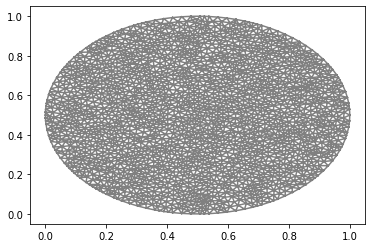

In [4]:
mesh = circle_mesh(mesh_center, mesh_radius, mesh_h)
# mesh_n = int(1./mesh_h)
# mesh = dl.UnitSquareMesh(mesh_n, mesh_n)
V = dl.FunctionSpace(mesh, 'CG', finite_element_order)
dl.plot(mesh)

X = V.tabulate_dof_coordinates()
N = V.dim()
d = mesh.geometric_dimension()

Make conductivity field $\kappa$ defined by
$$\kappa_{ij}(x) := \sum_{k=1}^4 w_k(x)\left(C_k\right)_{ij}$$
where $C_k$ are randomish matrices and $w_k$ are randomish smooth fields.

We build the functions $w_k$ on a very fine grid that always stays the same for reproducibility, then interpolate them to different coarser grid for different runs/numerical experiments.

Text(0.5, 1.0, 'f_23')

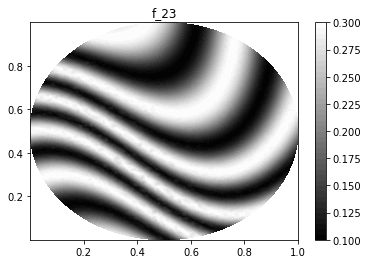

In [5]:
def wiggly_function(V0):
    n=150
    mesh = dl.RectangleMesh(dl.Point(-1.,-1.), dl.Point(2., 2.), n,n)
    V = dl.FunctionSpace(mesh, 'CG', 2)
    u = dl.interpolate(dl.Expression('0.2 + 0.1*sin(30*x[0])',domain=mesh, degree=5), V)
    old_coords = mesh.coordinates()

    xx0 = old_coords[:,0]
    yy0 = old_coords[:,1]

    xx1 = xx0
    yy1 = yy0 + 0.2 * np.cos(3.5*xx0)

    xx2 = yy1 + 0.3 * xx1
    yy2 = xx1 + 0.3 * np.sin(3.5*(yy1-0.35))

    xx3 = (xx2 + yy2)
    yy3 = (xx2 - yy2) + 0.2 * np.cos(4*(xx2 + yy2))

    new_coords = np.array([xx3, yy3]).T

    mesh.coordinates()[:] = new_coords

    u0 = dl.interpolate(u, V0)
    return u0

kappa = wiggly_function(V)

cm = dl.plot(kappa, cmap='gray')
plt.colorbar(cm)
plt.title(kappa)

Text(0.5, 1.0, 'zeta')

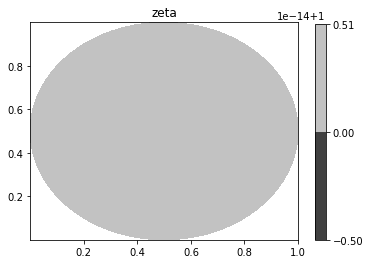

In [6]:
# zeta_expr = dl.Expression('200.0 * sin(2*pi*x[0]*x[1]-x[1]*x[1]-2.1)', degree=5, domain=mesh)
# zeta = dl.interpolate(zeta_expr, V)
zeta = load_image_into_fenics(V, 'aces_building.png')
# zeta.vector()[:] = 300. * (zeta.vector()[:] - 0.5)
zeta.vector()[:] = 1.

cm = dl.plot(zeta, cmap='gray')
plt.colorbar(cm)
plt.title('zeta')

In [7]:
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

mass_form = u_trial * v_test * dl.dx
M = dl.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

# stiffness_form = fenics.inner(kappa * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
stiffness_form = dl.inner(kappa * dl.grad(u_trial), dl.grad(v_test)) * dl.dx \
                 + zeta * u_trial * v_test * dl.dx
A = dl.assemble(stiffness_form)

In [8]:
delta_t = final_time_T / num_timesteps
Z_minus = M
Z_plus = M + delta_t * A

solve_Z_plus = make_fenics_amg_solver(Z_plus)

Text(0.5, 1.0, 'u0_true')

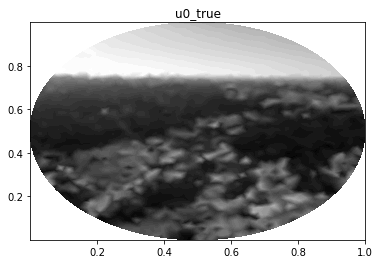

In [9]:
# zz = random_smooth_partition_of_unity(100, V, temperature=10, normalize=True)
# # zz = random_smooth_partition_of_unity(25, V, temperature=10, normalize=True)
#
# u0_true = fenics.Function(V)
# for k in range(len(zz)):
#     u0_true.vector()[:] = u0_true.vector() + (k**2) * zz[k].vector()

# u0_true = load_angel_peak_badlands_image_into_fenics(V)
u0_true = load_image_into_fenics(V, 'angel_peak_badlands.png')
# u0_true = load_image_into_fenics(V, 'aces_building.png')
plt.figure()

dl.plot(u0_true, cmap='gray')
plt.title('u0_true')

In [10]:
def forward_map(u0_petsc):
    uT_petsc = dl.Vector(u0_petsc)
    for k in range(num_timesteps):
        uT_petsc = solve_Z_plus(Z_minus * uT_petsc)
    return uT_petsc

Text(0.5, 1.0, 'uT_true')

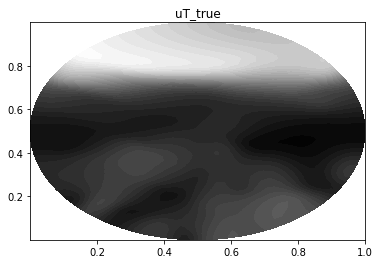

In [11]:
uT_true = dl.Function(V)
uT_true.vector()[:] = forward_map(u0_true.vector())
dl.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [12]:
def adjoint_map(vT_petsc):
    v0_petsc = dl.Vector(vT_petsc)
    for k in range(num_timesteps):
        v0_petsc = Z_minus * solve_Z_plus(v0_petsc)
    return v0_petsc

Perform adjoint correctness check

In [13]:
x = randn_fenics_function(V)
y = randn_fenics_function(V)
adjoint_err = np.abs(forward_map(x.vector()).inner(y.vector())
                     - x.vector().inner(adjoint_map(y.vector())))
print('adjoint_err=', adjoint_err)

adjoint_err= 3.5106091367254066e-09


true_noise_level= 9.890890098971443e-09


Text(0.5, 1.0, 'uT_obs')

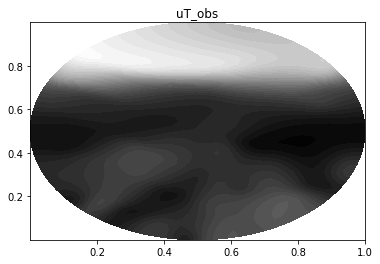

In [14]:
N = V.dim() 
normalized_noise = np.random.randn(N) / np.sqrt(N)
uT_obs = dl.Function(V)
uT_obs.vector()[:] = uT_true.vector()[:] + noise_level * normalized_noise * np.linalg.norm(uT_true.vector()[:])

true_noise_level = dl.norm(uT_obs.vector() - uT_true.vector())/dl.norm(uT_true.vector())
print('true_noise_level=', true_noise_level)
dl.plot(uT_obs, cmap='gray')
plt.title('uT_obs')

In [15]:
def objective(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    J = 0.5 * discrepancy.inner(M * discrepancy)
    return J

In [16]:
objective(u0_true.vector())

3.8597556436797975e-18

In [17]:
def gradient(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    return adjoint_map(M * discrepancy)

In [18]:
def apply_hessian(p_petsc):
    return adjoint_map(M * forward_map(p_petsc))

apply_Hd = apply_hessian
apply_Hd_t = apply_hessian

## Finite difference check for gradient and Hessian

In [19]:
u0 = dl.Function(V)
u0.vector()[:] = np.random.randn(V.dim())

J = objective(u0.vector())
g = gradient(u0.vector())

du = dl.Function(V)
du.vector()[:] = np.random.randn(V.dim())

In [20]:
ss = np.logspace(-15, 0, 11)
grad_errs = np.zeros(len(ss))
for k in range(len(ss)):
    s = ss[k]
    u0_2_vector = u0.vector() + s * du.vector()

    J2 = objective(u0_2_vector)
    dJ_diff = (J2 - J) / s
    dJ = g.inner(du.vector())
    grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    grad_errs[k] = grad_err

    print('s=', s, ', grad_err=', grad_err)

<ipython-input-20-a19fad4e0606>:10: RuntimeWarning: divide by zero encountered in double_scalars
  grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


s= 1e-15 , grad_err= inf
s= 3.1622776601683796e-14 , grad_err= 0.022915753978473306
s= 1e-12 , grad_err= 0.000979301364299267
s= 3.1622776601683794e-11 , grad_err= 7.200399253830084e-05
s= 1e-09 , grad_err= 1.1535307731670251e-06
s= 3.162277660168379e-08 , grad_err= 1.7111001946014251e-07
s= 1e-06 , grad_err= 7.761748258114087e-07
s= 3.1622776601683795e-05 , grad_err= 2.4463259739573582e-05
s= 0.001 , grad_err= 0.0007741847573966267
s= 0.03162277660168379 , grad_err= 0.025076390025203912
s= 1.0 , grad_err= 3.416694688495196


hess_err= 7.576025244614947e-10


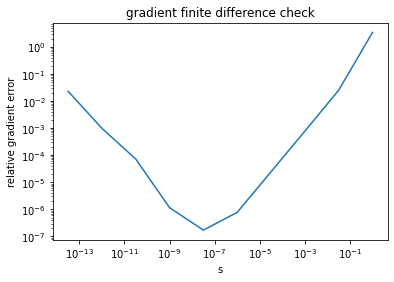

In [21]:
plt.figure()
plt.loglog(ss, grad_errs)
plt.title('gradient finite difference check')
plt.xlabel('s')
plt.ylabel('relative gradient error')

u0_2 = dl.Function(V)
u0_2.vector()[:] = np.random.randn(V.dim())
dg = apply_hessian(u0_2.vector() - u0.vector())
g2 = gradient(u0_2.vector())
dg_diff = g2 - g
hess_err = dl.norm(dg - dg_diff) / dl.norm(dg_diff)
print('hess_err=', hess_err)

## Visualize Hessian impulse responses

$$g \mapsto M^{-1} H M^{-1} g$$

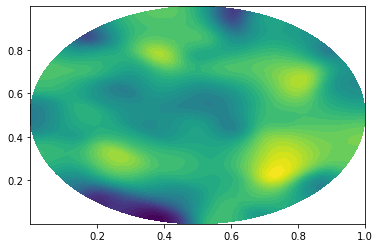

In [22]:
g = dl.Function(V)
g.vector()[:] = np.random.randn(V.dim())

Hg = dl.Function(V)
Hg.vector()[:] = solve_M(apply_Hd(solve_M(g.vector())))

dl.plot(Hg)

Text(0.5, 1.0, 'point source at [0.2 0.5]')

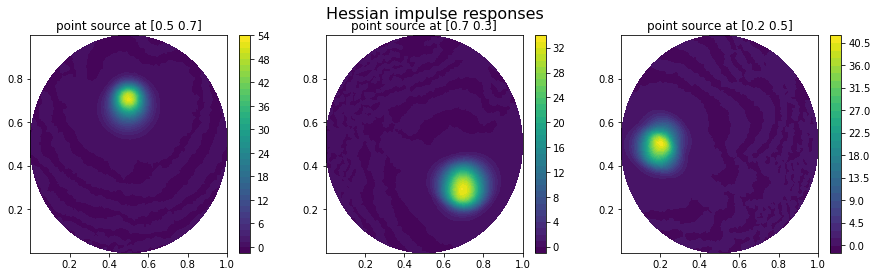

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle('Hessian impulse responses', fontsize=16)

plt.sca(axes[0])
pp = np.array([[0.5,0.7]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[1])
pp = np.array([[0.7,0.3]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[2])
pp = np.array([[0.2,0.5]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

making mass matrix and solver
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
done
getting nodes on boundary
done
computing inds of points far from boundary
done


/home/nick/repos/localpsf/code/localpsf_helpers.py:65: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :], mu_perm[x_ind, :],


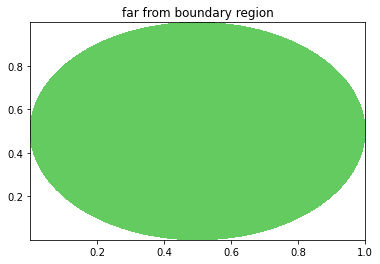

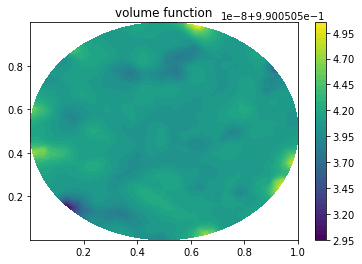

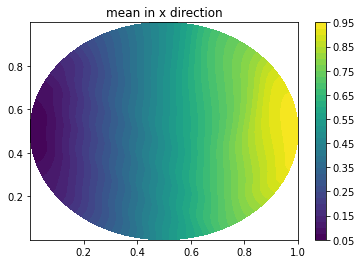

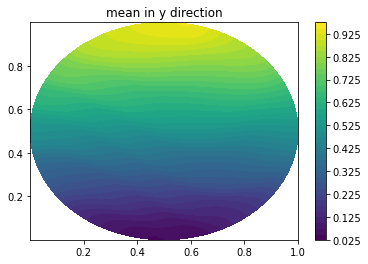

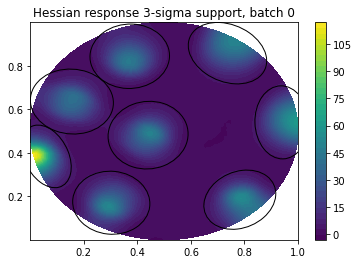

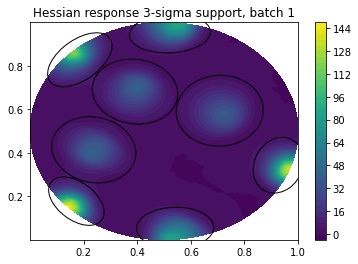

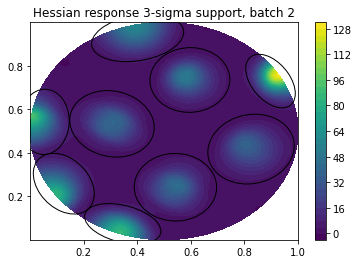

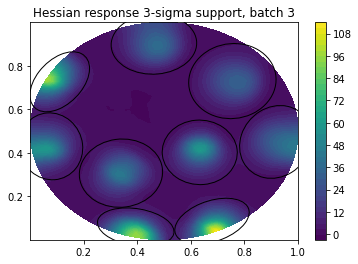

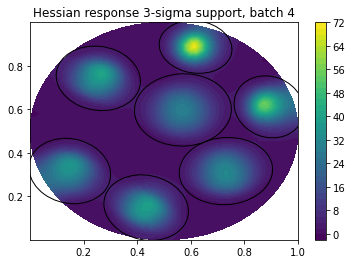

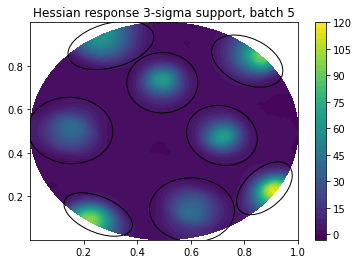

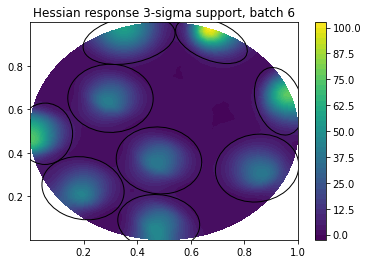

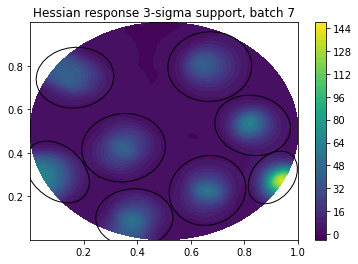

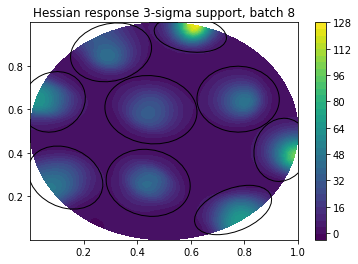

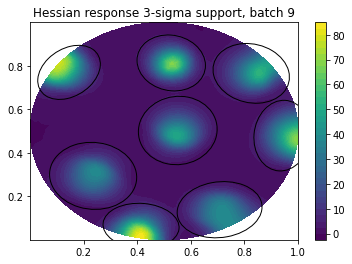

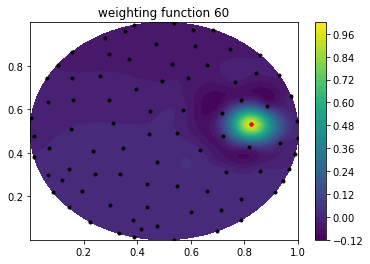

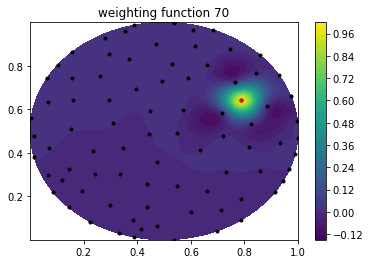

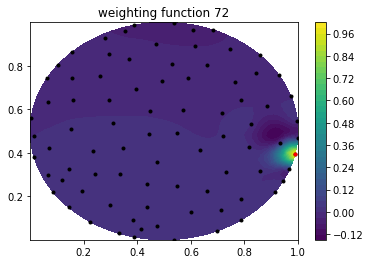

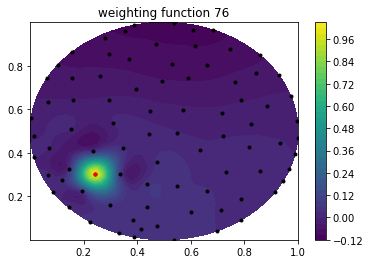

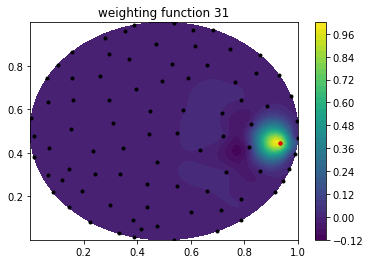

In [24]:
lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=10, num_standard_deviations_tau=2.5)
# lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=5, num_standard_deviations_tau=2.5)

lpsf.make_plots()

Forming weighting function patches and (un-extended) convolution kernel patches


  0%|          | 0/83 [00:00<?, ?it/s]

Filling in missing kernel entries using neighboring kernels


  0%|          | 0/83 [00:00<?, ?it/s]

Building cluster trees and block cluster tree
Building product convolution hmatrix from patches


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:212: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array)


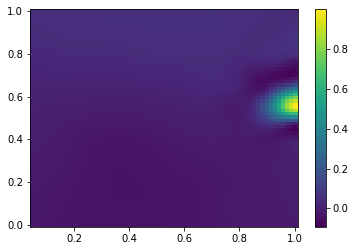

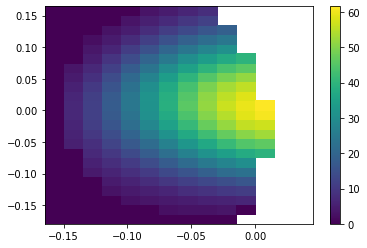

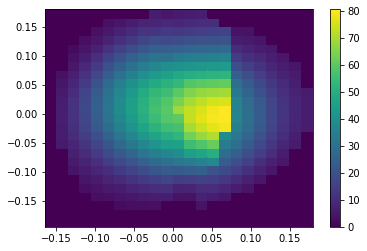

In [25]:
ww = lpsf.weighting_functions
ff_batches = lpsf.dirac_comb_responses
pp = np.vstack(lpsf.point_batches)
all_mu = np.vstack(lpsf.mu_batches)
all_Sigma = np.vstack(lpsf.Sigma_batches)
tau = lpsf.tau
batch_lengths = [ppk.shape[0] for ppk in lpsf.point_batches]

Hd_hmatrix, WW, FF, initial_FF = \
    build_product_convolution_hmatrix_from_fenics_functions(ww, ff_batches, batch_lengths, pp,
                                                            all_mu, all_Sigma, tau, 
                                                            w_support_rtol=2e-2, return_extras=True)

k=0

WW[k].plot()
initial_FF[k].plot()
FF[k].plot()

dt_hessian= 0.08260107040405273
dt_hmatrix= 0.002476215362548828
err_matvec= 0.1798321059651957


Text(0.5, 1.0, 'err')

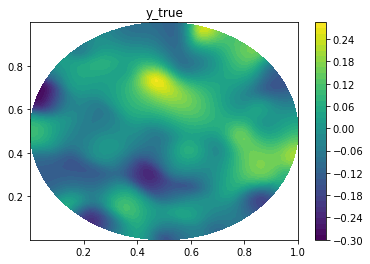

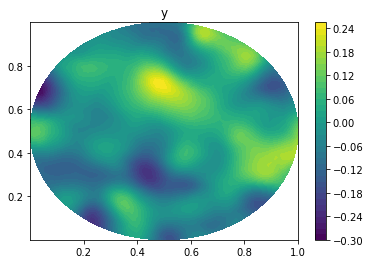

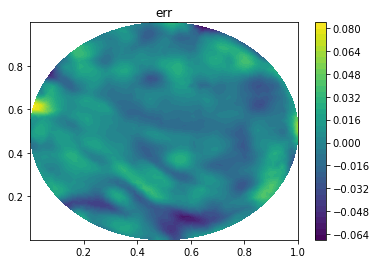

In [26]:
z = dl.Function(V)
z.vector()[:] = np.random.randn(V.dim())
# z.vector()[:] = kappa.vector()[:].copy()

y_true = dl.Function(V)
t = time()
y_true.vector()[:] = solve_M(apply_Hd(z.vector()))
dt_hessian = time() - t
print('dt_hessian=', dt_hessian)

y = dl.Function(V)
t = time()
y.vector()[:] = Hd_hmatrix * (M * z.vector()[:]) # Good
# y.vector()[:] = PC.matvec(z.vector()[:])
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

plt.figure()
cm = dl.plot(y_true)
plt.colorbar(cm)
plt.title('y_true')

plt.figure()
cm = dl.plot(y)
plt.colorbar(cm)
plt.title('y')

err_matvec = np.linalg.norm(y.vector()[:] - y_true.vector()[:])/np.linalg.norm(y_true.vector()[:])

print('err_matvec=', err_matvec)

ee = dl.Function(V)
ee.vector()[:] = y.vector()[:] - y_true.vector()[:]

plt.figure()
cm = dl.plot(ee)
plt.colorbar(cm)
plt.title('err')

  0%|          | 0/30 [00:00<?, ?it/s]

norm_Hd= 4.5035701099525145 , norm_Hd_err= 0.8267113794537706
relative_Hd_err= 0.1835680047762124


Text(0.5, 1.0, 'Hd_relative_err_fct')

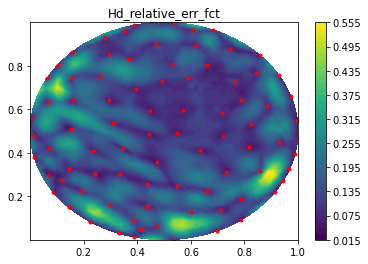

In [27]:
apply_Hd_t = apply_Hd
Hd_hmatrix_T = Hd_hmatrix.T

def apply_M_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return (M * x.vector())[:]
    

def solve_M_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return solve_M(x.vector())[:]

def apply_Hd_t_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return solve_M_numpy(apply_Hd_t(x.vector())[:])

n_random = 30
Omega = np.random.randn(V.dim(), n_random)
Y_true = np.zeros((V.dim(), n_random))
Y = np.zeros((V.dim(), n_random))
for k in tqdm(range(n_random)):
    Y_true[:,k] = apply_Hd_t_numpy(Omega[:,k])
    Y[:,k] = Hd_hmatrix_T.matvec(apply_M_numpy(Omega[:,k])) #
    # Y_true[lpsf.inds_of_points_far_from_boundary,k] = apply_Hd_t_numpy(Omega[:,k])[lpsf.inds_of_points_far_from_boundary]
    # Y[lpsf.inds_of_points_far_from_boundary,k] = Hd_hmatrix_T.matvec(Omega[:,k])[lpsf.inds_of_points_far_from_boundary] #

norm_Hd = np.linalg.norm(Y_true) / np.sqrt(n_random)
norm_Hd_err = np.linalg.norm(Y_true - Y) / np.sqrt(n_random)

relative_Hd_err = norm_Hd_err / norm_Hd
print('norm_Hd=', norm_Hd, ', norm_Hd_err=', norm_Hd_err)
print('relative_Hd_err=', relative_Hd_err)

Hd_norm_vec = np.linalg.norm(Y_true, axis=1) / np.sqrt(n_random)
Hd_err_vec = np.linalg.norm(Y_true - Y, axis=1) / np.sqrt(n_random)
Hd_relative_err_vec = Hd_err_vec / Hd_norm_vec
Hd_relative_err_fct = dl.Function(V)
Hd_relative_err_fct.vector()[:] = Hd_relative_err_vec

cm = dl.plot(Hd_relative_err_fct)
plt.colorbar(cm)

plt.plot(lpsf.points[:, 0], lpsf.points[:, 1], '.r')

plt.title('Hd_relative_err_fct')

In [28]:
Hd_hmatrix.cpp_object

In [29]:
Hd_hmatrix.visualize('Hd_hmatrix')

In [30]:
Hd_plus = hpro.rational_positive_definite_approximation_method1(Hd_hmatrix, rtol_inv=1e-2, rtol_add=1e-6)

A.sym(): lambda_min= -54.38394846104529 , lambda_max= 3011.551494492917
━━ H-matrix inverse ( rtol =  0.01 , atol =  1e-15 , overwrite= True  )
    done in  14.03722882270813
    size of inverse =  16224233  bytes


In [31]:
Hd_plus.visualize('Hd_plus')

dt_hessian= 0.09726262092590332
dt_hmatrix= 0.003155231475830078
err_matvec= 0.1560080720892027


Text(0.5, 1.0, 'err')

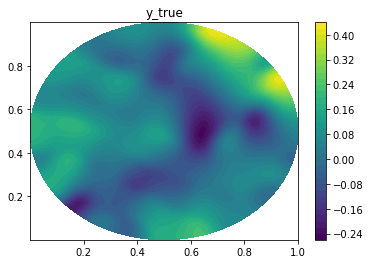

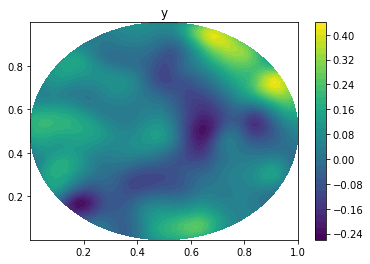

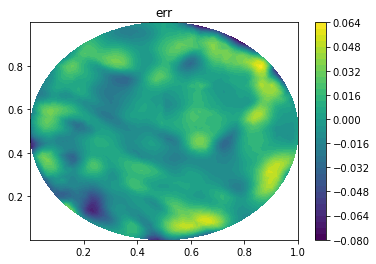

In [32]:
z = dl.Function(V)
z.vector()[:] = np.random.randn(V.dim())
# z.vector()[:] = kappa.vector()[:].copy()
# z.vector()[:] = solve_M(apply_Hd(z.vector()))

y_true = dl.Function(V)
t = time()
y_true.vector()[:] = solve_M(apply_Hd(z.vector()))
dt_hessian = time() - t
print('dt_hessian=', dt_hessian)

y = dl.Function(V)
t = time()
y.vector()[:] = Hd_plus * (M * z.vector()[:])
# y.vector()[:] = Hd_hmatrix * (M * z.vector()[:]) # Good
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

plt.figure()
cm = dl.plot(y_true)
plt.colorbar(cm)
plt.title('y_true')

plt.figure()
cm = dl.plot(y)
plt.colorbar(cm)
plt.title('y')

err_matvec = np.linalg.norm(y.vector()[:] - y_true.vector()[:])/np.linalg.norm(y_true.vector()[:])

print('err_matvec=', err_matvec)

ee = dl.Function(V)
ee.vector()[:] = y.vector()[:] - y_true.vector()[:]

plt.figure()
cm = dl.plot(ee)
plt.colorbar(cm)
plt.title('err')

  0%|          | 0/30 [00:00<?, ?it/s]

norm_Hd= 4.565343275413017 , norm_Hd_err= 0.7793479391210653
relative_Hd_err= 0.17070960322267537


Text(0.5, 1.0, 'Hd_relative_err_fct')

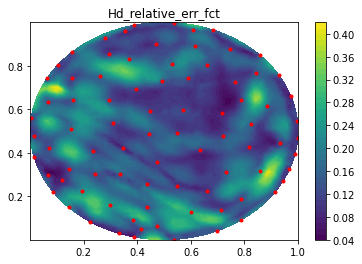

In [33]:
Hd_plus_T = Hd_plus.T
# Hd_plus_T = Hd_hmatrix.sym()

n_random = 30
Omega = np.random.randn(V.dim(), n_random)
Y_true = np.zeros((V.dim(), n_random))
Y = np.zeros((V.dim(), n_random))
for k in tqdm(range(n_random)):
    Y_true[:,k] = apply_Hd_t_numpy(Omega[:,k])
    Y[:,k] = Hd_plus_T.matvec(apply_M_numpy(Omega[:,k])) #
    # Y_true[lpsf.inds_of_points_far_from_boundary,k] = apply_Hd_t_numpy(Omega[:,k])[lpsf.inds_of_points_far_from_boundary]
    # Y[lpsf.inds_of_points_far_from_boundary,k] = Hd_hmatrix_T.matvec(Omega[:,k])[lpsf.inds_of_points_far_from_boundary] #

norm_Hd = np.linalg.norm(Y_true) / np.sqrt(n_random)
norm_Hd_err = np.linalg.norm(Y_true - Y) / np.sqrt(n_random)

relative_Hd_err = norm_Hd_err / norm_Hd
print('norm_Hd=', norm_Hd, ', norm_Hd_err=', norm_Hd_err)
print('relative_Hd_err=', relative_Hd_err)

Hd_norm_vec = np.linalg.norm(Y_true, axis=1) / np.sqrt(n_random)
Hd_err_vec = np.linalg.norm(Y_true - Y, axis=1) / np.sqrt(n_random)
Hd_relative_err_vec = Hd_err_vec / Hd_norm_vec
Hd_relative_err_fct = dl.Function(V)
Hd_relative_err_fct.vector()[:] = Hd_relative_err_vec

cm = dl.plot(Hd_relative_err_fct)
plt.colorbar(cm)

plt.plot(lpsf.points[:, 0], lpsf.points[:, 1], '.r')

plt.title('Hd_relative_err_fct')

In [34]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)

K_csc = csr_fenics2scipy(K)
M_csc = csr_fenics2scipy(M)

R_csc = K_csc + 1e0*M_csc

In [35]:
M_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(M_csc, Hd_plus.bct)
R_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(R_csc, Hd_plus.bct)

M_hmatrix.visualize("heat_inverse_problem_R_hmatrix")

In [36]:
a_reg

5e-05

In [37]:
def apply_H(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec
    y_vec = apply_Hd(x.vector())[:] + a_reg*(R_csc*x_vec)
    return y_vec

H_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

In [38]:
# H_hmatrix = M_hmatrix * (Hd_hmatrix * M_hmatrix) + a_reg * R_hmatrix
# H_hmatrix = M_hmatrix * (Hd_plus * M_hmatrix) + a_reg * R_hmatrix
H_hmatrix = hpro.h_mul(M_hmatrix, hpro.h_mul(Hd_plus, M_hmatrix, rtol=1e-2), rtol=1e-2) + a_reg * R_hmatrix
H_hmatrix = H_hmatrix.sym(overwrite=True)
H_hmatrix._set_nonsym()

H_hmatrix.visualize("H_hmatrix")

In [39]:
factorized_H = hpro.h_lu(H_hmatrix, overwrite=False, rtol=1e-6)

factorized_H.visualize('factorized_H')

x = np.random.randn(V.dim())

err_H_matrix_factorization = np.linalg.norm(x - H_hmatrix * factorized_H.solve(x))/np.linalg.norm(x)
print('err_H_matrix_factorization=', err_H_matrix_factorization)

━━  LU  factorisation ( rtol =  1e-06 , atol =  1e-12 , overwrite= False  )
    done in  21.661142349243164
    size of factors =  27946881  bytes
err_H_matrix_factorization= 4.436587001602517e-08


res_x_true= 5.928795500256227e-11
CG: no preconditioner
k=0, res=0.4560313251428746, err=0.6646889121973768
k=1, res=0.2792153225210386, err=0.40669697749420114
k=2, res=0.1667162831281439, err=0.2391713532333056
k=3, res=0.10284872122595018, err=0.15084342568345716
k=4, res=0.06250196269802621, err=0.09428219645428391
k=5, res=0.03772489345456914, err=0.05791666630363178
k=6, res=0.023035122064595688, err=0.03545338391843286
k=7, res=0.01422325509890964, err=0.021414967704523048
k=8, res=0.00857549076460142, err=0.012913503324735686
k=9, res=0.005183286088141446, err=0.007884259743884497
k=10, res=0.003167649128170167, err=0.004674719707470274
k=11, res=0.0019634766505412763, err=0.002814442521313161
k=12, res=0.0011994765343989588, err=0.0016628653450966664
k=13, res=0.0006901587304193435, err=0.000980488766469023
k=14, res=0.0004116657371958078, err=0.0005955431389017057
k=15, res=0.0002513789695413704, err=0.00035155889522559203
k=16, res=0.00014649632915688477, err=0.0002019950707

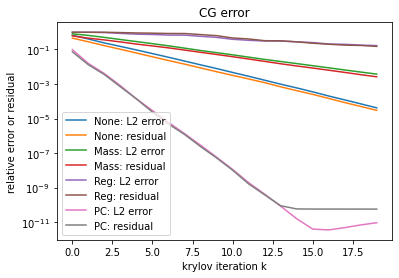

In [69]:
krylov_iter=20
krylov_tol=1e-12

M_linop = spla.LinearOperator(M_csc.shape, matvec=lambda x: M_csc * x)
solve_M = spla.factorized(M_csc)
solve_M_linop = spla.LinearOperator(M_csc.shape, matvec=solve_M)

R_linop = spla.LinearOperator(R_csc.shape, matvec=lambda x: a_reg * (R_csc * x))
solve_R = spla.factorized(a_reg * R_csc)
solve_R_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=solve_R)

b = np.random.randn(V.dim())

iH = factorized_H.as_linear_operator(inverse=True)

x_true = spla.gmres(H_linop, b, M=iH, restart=25, maxiter=1, tol=1e-12)[0]
res_x_true = np.linalg.norm(apply_H(x_true) - b)/np.linalg.norm(b)
print('res_x_true=', res_x_true)

iters_to_save = [1,5,10,15]

print('CG: no preconditioner')
x_none, _, res_none, errs_none, kk_none, xx_none = \
    custom_cg(H_linop, b, x_true=x_true, iters_to_save=iters_to_save, 
              maxiter=krylov_iter, tol=krylov_tol)

print('CG: mass matrix preconditioner')
x_mass, _, res_mass, errs_mass, kk_none, xx_mass = \
    custom_cg(H_linop, b, M=solve_M_linop, x_true=x_true, iters_to_save=iters_to_save, 
              maxiter=krylov_iter, tol=krylov_tol)

print('CG: regularization preconditioning')
x_reg, _, res_reg, errs_reg, kk_reg, xx_reg = \
    custom_cg(H_linop, b, M=solve_R_linop, x_true=x_true, iters_to_save=iters_to_save, 
              maxiter=krylov_iter, tol=krylov_tol)

print('CG: product-convolution preconditioning')
x_pc, _, res_pc, errs_pc, kk_pc, xx_pc = \
    custom_cg(H_linop, b, M=iH, x_true=x_true, iters_to_save=iters_to_save, 
              maxiter=krylov_iter, tol=krylov_tol)


plt.figure()
plt.semilogy(errs_none)
plt.semilogy(res_none)
plt.semilogy(errs_mass)
plt.semilogy(res_mass)
plt.semilogy(errs_reg)
plt.semilogy(res_reg)
plt.semilogy(errs_pc)
plt.semilogy(res_pc)
plt.title('CG error')
plt.xlabel('krylov iteration k')
plt.ylabel('relative error or residual')
plt.legend(['None: L2 error', 'None: residual', 
            'Mass: L2 error', 'Mass: residual',
            'Reg: L2 error', 'Reg: residual', 
            'PC: L2 error', 'PC: residual'])
plt.show()

In [72]:
ee_mass, P_mass = spla.eigsh(H_linop, k=200, M=M_linop, Minv=solve_M_linop, which='LM')

ee_mass

array([3.18526268, 3.18654479, 3.19061756, 3.19750088, 3.19802053,
       3.19943914, 3.20026568, 3.20548606, 3.20682679, 3.21434549,
       3.21554628, 3.21700419, 3.23265096, 3.23321209, 3.23687594,
       3.2386655 , 3.23962473, 3.24264357, 3.25049679, 3.2543008 ,
       3.25653343, 3.26169963, 3.27416627, 3.27979037, 3.28853129,
       3.29256707, 3.29500201, 3.30189029, 3.30276172, 3.30522212,
       3.3065676 , 3.31230811, 3.31517937, 3.31899286, 3.33663751,
       3.33781655, 3.34215826, 3.3444502 , 3.34735238, 3.35220794,
       3.352447  , 3.36131402, 3.3632987 , 3.36903676, 3.37676657,
       3.38089417, 3.38317745, 3.38570444, 3.38916718, 3.39886783,
       3.40705006, 3.41095945, 3.41185284, 3.41863051, 3.4203141 ,
       3.42431081, 3.4258171 , 3.42691323, 3.42705569, 3.42722249,
       3.43039984, 3.43404067, 3.43484737, 3.44022125, 3.44061392,
       3.4412328 , 3.44435183, 3.45320987, 3.45364323, 3.45642199,
       3.46206867, 3.47706023, 3.48423855, 3.48511984, 3.48699

In [73]:
ee_reg, P_reg = spla.eigsh(H_linop, k=200, M=R_linop, Minv=solve_R_linop, which='LM')

ee_reg - 1.

array([2.05332227e-02, 2.07072284e-02, 2.32468077e-02, 2.35588261e-02,
       2.47428447e-02, 2.50742679e-02, 2.64060598e-02, 2.71301609e-02,
       2.85330440e-02, 2.91422308e-02, 2.99624808e-02, 3.08375058e-02,
       3.20546030e-02, 3.24940943e-02, 3.36969759e-02, 3.54288260e-02,
       3.66375650e-02, 3.77740534e-02, 4.01953674e-02, 4.17126723e-02,
       4.20750202e-02, 4.54855188e-02, 4.72082349e-02, 4.85812684e-02,
       5.12681191e-02, 5.19730335e-02, 5.28964090e-02, 5.48320073e-02,
       5.71588126e-02, 5.99343846e-02, 6.23180694e-02, 6.34895186e-02,
       6.50159905e-02, 7.11318500e-02, 7.26342143e-02, 7.38323919e-02,
       7.66240271e-02, 8.01765067e-02, 8.20943599e-02, 8.68907129e-02,
       9.26718572e-02, 9.53717803e-02, 9.74863777e-02, 1.00437531e-01,
       1.01543722e-01, 1.06318311e-01, 1.12811988e-01, 1.15564947e-01,
       1.19913211e-01, 1.21212584e-01, 1.29641471e-01, 1.32906929e-01,
       1.38956006e-01, 1.40547216e-01, 1.49483779e-01, 1.57742418e-01,
      

In [ ]:
E_pc_linop = spla.LinearOperator(H_linop.shape, matvec=lambda x: H_linop*x - H_hmatrix * x)

ee_pc, P_pc = spla.eigsh(E_pc_linop, k=500, M=H_hmatrix, Minv=iH, which='LM')

ee_pc

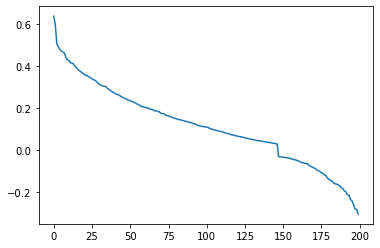

In [82]:
plt.plot(ee_pc[::-1])

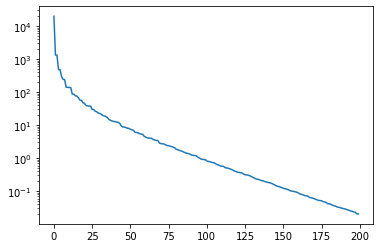

In [81]:
plt.semilogy(ee_reg[::-1] - 1.)

In [84]:
(1 + ee_pc)[-1] / (1 + ee_pc)[0]

2.352997758214011

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, '-gradient at zero')

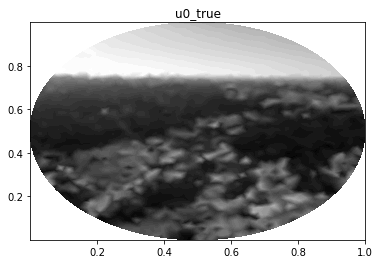

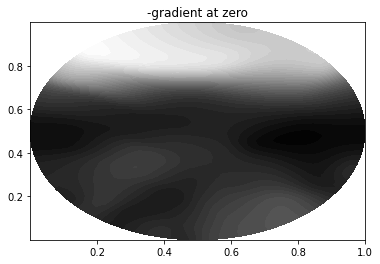

In [70]:
z0 = fenics.Function(V)

g_dual = gradient(z0.vector())
g = g_dual[:]
g_reisz = fenics.Function(V)
g_reisz.vector()[:] = solve_M(g_dual)

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

plt.figure()
fenics.plot(-g_reisz, cmap='gray')
plt.title('-gradient at zero')

u0_err_exact= 4.123846131887409e-11


Text(0.5, 1.0, 'uT_true')

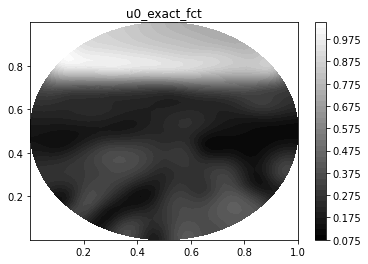

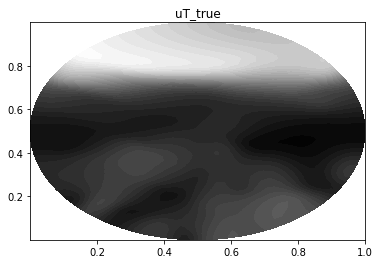

In [74]:
u0_exact = spla.gmres(H_linop, -g, M=factorized_H.as_linear_operator(inverse=True), restart=50, maxiter=1, tol=krylov_tol)[0]
u0_err_exact = np.linalg.norm(apply_H(u0_exact) + g)/np.linalg.norm(g)
print('u0_err_exact=', u0_err_exact)

u0_exact_fct = fenics.Function(V)
u0_exact_fct.vector()[:] = u0_exact
cm = fenics.plot(u0_exact_fct, cmap='gray')
plt.colorbar(cm)
plt.title('u0_exact_fct')

uf_fct = fenics.Function(V)
uf_fct.vector()[:] = forward_map(u0_exact_fct.vector())

uf_true_fct = fenics.Function(V)
uf_true_fct.vector()[:] = forward_map(u0_true.vector())

plt.figure()
fenics.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [ ]:
morozov_discrepancy = np.sqrt(fenics.assemble((uf_true_fct - uf_fct)**2 * fenics.dx))

obs_norm = np.sqrt(fenics.assemble(uf_true_fct**2 * fenics.dx))

morozov_relative_noise_level = morozov_discrepancy / obs_norm
# morozov_discrepancy = np.sqrt(2.0 * objective(u0_exact_fct.vector()))

# fenics.assemble(uf_true_fct * fenics.dx)
#
# morozov_discrepancy2 = np.linalg.norm(uf_true[:] - uf[:])/np.linalg.norm(uf_true[:])

print('morozov_discrepancy=', morozov_discrepancy, ', obs_norm=', obs_norm)
print('morozov_relative_noise_level=', morozov_relative_noise_level)

In [ ]:
krylov_iter=15
krylov_tol=1e-12

u0_none = spla.gmres(H_linop, -g, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_none = np.linalg.norm(apply_H(u0_none) + g)/np.linalg.norm(g)
print('u0_err_none=', u0_err_none)

u0_R = spla.gmres(H_linop, -g, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_reg = np.linalg.norm(apply_H(u0_R) + g)/np.linalg.norm(g)
print('u0_err_reg=', u0_err_reg)

u0_pre = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_pre = np.linalg.norm(apply_H(u0_pre) + g)/np.linalg.norm(g)
print('u0_err_pre=', u0_err_pre)

plt.figure()
u0_none_fct = fenics.Function(V)
u0_none_fct.vector()[:] = u0_none
fenics.plot(u0_none_fct, cmap='gray')
plt.title('u0_none_fct')

plt.figure()
u0_R_fct = fenics.Function(V)
u0_R_fct.vector()[:] = u0_R
fenics.plot(u0_R_fct, cmap='gray')
plt.title('u0_R_fct')

plt.figure()
u0_pre_fct = fenics.Function(V)
u0_pre_fct.vector()[:] = u0_pre
fenics.plot(u0_pre_fct, cmap='gray')
plt.title('u0_pre_fct')

In [ ]:
Z_linop = spla.LinearOperator(H_linop.shape, matvec=lambda x:H_linop.matvec(x) - H_hmatrix.matvec(x))
#
# dd, P = spla.eigsh(Z_linop, k=6, M=H_hmatrix_sym, Minv=H_hmatrix_sym_factorized, mode='buckling', which='LM')

A_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:iH_hmatrix.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(iH_hmatrix.matvec(x))-x)

AR_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:solve_R_linop.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(solve_R_linop.matvec(x))-x)

# _,ss,_ = spla.svds(Q_linop, k=6, which='LM')

_,ss,_ = basic_randomized_svd(A_linop, 100)
_,ssR,_ = basic_randomized_svd(AR_linop, 100)

$$P^{-1} H - I = U \Sigma V^T$$

$$P$$ is either $R$ or our preconditioner

In [ ]:
plt.figure()
plt.semilogy(ss)
plt.semilogy(ssR)
plt.legend(['ss', 'ssR'])
plt.title('preconditioned singular values')

In [ ]:
ss

In [ ]:
Happrox_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    Happrox_dense[k,:] = Hfull_hmatrix * ek

In [ ]:
plt.matshow(Happrox_dense)

In [ ]:
H_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    H_dense[k,:] = apply_Hfull(ek)

In [ ]:
np.linalg.norm(Happrox_dense - H_dense)/np.linalg.norm(H_dense)

In [ ]:
invH_hmatrix = hpro.convert_sparse_csc_matrix_to_hmatrix(a_reg*R_csc, ct, ct, bct)
hpro.hmatrix_add_overwrites_second(A_hmatrix, invH_hmatrix, 1e-6)
hpro.hmatrix_factorized_inverse_destructive(invH_hmatrix, 1e-6)

def apply_invH_approx(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec

    iHMx = fenics.Function(V)
    iHMx.vector()[:] = hpro.hmatrix_matvec(invH_hmatrix, ct, ct, (M * x.vector())[:])
    return (M * iHMx.vector())[:]

apply_invH_approx_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_invH_approx)

In [ ]:
iH_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    iH_dense[k,:] = apply_invH_approx(ek)

In [ ]:
plt.matshow(H_dense - a_reg*R_csc.toarray())

In [ ]:
_,ss,_ = np.linalg.svd(G)
ss
plt.semilogy(ss)

In [ ]:

# x2 = hpro.hmatrix_factorized_inverse_matvec(inv_A, ct, ct, y)

In [ ]:
ek = fenics.Function(V).vector()
A_true = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    ek[:] = 0.
    ek[k] = 1.
    A_true[:,k] = apply_H(ek)[:]

In [ ]:
plt.matshow(A_true)

In [ ]:
iM_A_iM = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    q0 = X[k,:].reshape((1,-1))
    qq = np.dot(np.ones((V.dim(),1)), q0)
    iM_A_iM[k,:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)[:]
    

In [ ]:
M_numpy = M.array()
A_approx = np.dot(M_numpy, np.dot(iM_A_iM, M_numpy))
# A_approx = np.dot(M_numpy, iM_A_iM)

In [ ]:
plt.matshow(A_approx)

In [ ]:
np.linalg.norm(A_approx - A_true)/np.linalg.norm(A_true)

In [ ]:
PI.gaussian_kernel_widths

In [ ]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)
K_numpy = K.array()

Reg = K_numpy + 1e0*M_numpy

_,ssM,_ = np.linalg.svd(M_numpy)
_,ssK,_ = np.linalg.svd(K_numpy)
_,ssR,_ = np.linalg.svd(Reg)

plt.semilogy(ssM)
plt.semilogy(ssK)
plt.semilogy(ssR)
plt.legend(['M', 'K', 'R'])

In [ ]:
a_reg = 2e-5
H_true = A_true + a_reg * Reg
H_true = (H_true + H_true.T)/2.
H_approx0 = A_approx + a_reg * Reg
H_approx = (H_approx0 + H_approx0.T)/2.

In [ ]:
U,ss_true,_ = np.linalg.svd(A_true)
ss_approx = np.abs(np.diagonal(np.dot(U.T,np.dot(A_approx,U))))
ss_reg = np.diagonal(np.dot(U.T,np.dot(Reg,U)))

In [ ]:
plt.semilogy(ss_true[:500])
plt.semilogy(ss_approx[:500])
plt.semilogy(a_reg*ss_reg[:500])
plt.legend(['A_true', 'A_approx', 'Reg'])
plt.xlabel('i')
plt.ylabel('lambda_i')

In [ ]:
H_pre = np.linalg.solve(H_approx, H_true)
_,ss_pre,_ = np.linalg.svd(H_pre)

H_preR = np.linalg.solve(a_reg * Reg, H_true)
_,ss_preR,_ = np.linalg.svd(H_preR)

In [ ]:
plt.figure()
plt.semilogy(ss_pre)
plt.semilogy(ss_preR)
plt.legend(['H_pre', 'H_preR'])
plt.xlabel('i')
plt.ylabel('lambda_i')

cond_pre = np.max(ss_pre)/np.min(ss_pre)
cond_preR = np.max(ss_preR)/np.min(ss_preR)

print('cond_pre=', cond_pre)
print('cond_preR=', cond_preR)

## Random RHS

In [ ]:
krylov_iter=20
krylov_tol=1e-12

b = np.random.randn(V.dim())
x_true = np.linalg.solve(H_true, b)

x_R = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(x_true - x_R)/np.linalg.norm(x_true)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_true, b, M=np.linalg.inv(H_approx), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(x_true - x_pre)/np.linalg.norm(x_true)
print('err_pre=', err_pre)

## Gradient RHS

### Try deflating spectrum

In [ ]:
H_pre2 = np.linalg.solve(H_approx, H_true)
U,ss,Vt = np.linalg.svd(H_pre2 - np.eye(V.dim()))

In [ ]:
r2 = 5
plt.semilogy(ss)
np.sum(ss > r2)

In [ ]:
P = H_approx2
delta_P = np.dot(P, np.dot(U[:,:r2], np.dot(np.diag(ss[:r2]), Vt[:r2,:])))
P2 = P + delta_P
H_pre3 = np.linalg.solve(P2, H_true)

In [ ]:
_,ll0,_ = np.linalg.svd(H_true)
_,ll1,_ = np.linalg.svd(P)
_,ll2,_ = np.linalg.svd(P2)

plt.semilogy(ll0)
plt.semilogy(ll1)
plt.semilogy(ll2)

In [ ]:
e0 = np.linalg.norm(P - H_true)/np.linalg.norm(H_true)
e1 = np.linalg.norm(P2 - H_true)/np.linalg.norm(H_true)
print('e0=', e0)
print('e1=', e1)

In [ ]:
import scipy.sparse.linalg as spla

# b_form = fenics.Expression('sin(5*x[0])*cos(3*x[1]) + x[0]*x[1]', degree=1)*fenics.TestFunction(V)*fenics.dx
# b = fenics.assemble(b_form)[:]
# b = np.random.randn(V.dim())
b = np.dot(H_true, ww[1].vector()[:])
b_fct = fenics.Function(V)
b_fct.vector()[:] = np.linalg.solve(M_numpy, b)
x_true = np.linalg.solve(H_true, b)

x_approx = np.linalg.solve(H_approx2, b)
x_approx3 = np.linalg.solve(P2, b)

err_approx = np.linalg.norm(x_true - x_approx)/np.linalg.norm(x_true)
print('err_approx=', err_approx)

err_approx3 = np.linalg.norm(x_true - x_approx3)/np.linalg.norm(x_true)
print('err_approx3=', err_approx3)

x_true_fct = fenics.Function(V)
x_true_fct.vector()[:] = x_true

x_approx_fct = fenics.Function(V)
x_approx_fct.vector()[:] = x_approx

x_approx3_fct = fenics.Function(V)
x_approx3_fct.vector()[:] = x_approx3

fenics.plot(x_true_fct)
plt.figure()
fenics.plot(x_approx_fct)
plt.figure()
fenics.plot(x_approx3_fct)

In [ ]:
fenics.plot(b_fct)

In [ ]:
iter = 20
krylov_tol = 1e-12

x0 = spla.gmres(H_true, b, restart=iter, maxiter=1, tol=krylov_tol)[0]
# x0 = spla.gmres(H_true, b, maxiter=iter)[0]
err0 = np.linalg.norm(x_true - x0)/np.linalg.norm(x_true)
# err0 = np.linalg.norm(np.dot(H_true,x0) - b)/np.linalg.norm(b)
print('err0=', err0)

x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), maxiter=iter)[0]
# x1 = spla.minres(H_true, b, M=Reg, maxiter=iter)[0]
# x1 = spla.gmres(H_true, b, M=Reg, maxiter=iter)[0]
err1 = np.linalg.norm(x_true - x1)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x1) - b)/np.linalg.norm(b)
print('err1=', err1)

x2 = spla.gmres(H_true, b, M=np.linalg.inv((H_approx+H_approx.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv((P2+P2.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.minres(H_true, b, M=np.linalg.inv(H_approx2), maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv(H_approx2), restart=iter, maxiter=1)[0]
# x2 = spla.minres(H_true, b, M=H_approx2, maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=H_approx2, maxiter=iter)[0]
err2 = np.linalg.norm(x_true - x2)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x2) - b)/np.linalg.norm(b)
print('err2=', err2)

x1_fct = fenics.Function(V)
x1_fct.vector()[:] = x1

fenics.plot(x1_fct)
plt.title('x1_fct')

plt.figure()
x2_fct = fenics.Function(V)
x2_fct.vector()[:] = x2

cm = fenics.plot(x2_fct)
plt.title('x2_fct')
plt.colorbar(cm)

plt.figure()
cm = fenics.plot(x_true_fct - x1_fct)
plt.colorbar(cm)
plt.title('err1 function')

plt.figure()
cm = fenics.plot(x_true_fct - x2_fct)
plt.colorbar(cm)
plt.title('err2 function')

In [ ]:
err0

In [ ]:
point_batches = list()
dirac_comb_responses = list()
dirac_comb_response_evaluators = list()
mu_batches = list()
Sigma_batches = list()
PSI = PoissonSquaredInterpolation(V)

def add_new_batch():
    new_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
    new_points = candidate_points[new_batch_inds, :]
    point_batches.append(new_points)
    candidate_inds = list(np.setdiff1d(candidate_inds, new_inds))

    mu_batches.append(eval_mu(new_points))
    all_Sigma_batches.append(eval_Sigma(new_points))
    
    new_dirac_comb_response = get_dirac_comb_response(new_batch_points)
    dirac_comb_responses.append(new_dirac_comb_response)
    dirac_comb_response_evaluators.append(FenicsFunctionFastGridEvaluator(new_dirac_comb_response))
    
    PSI.add_points([new_points[k,:] for k in range(new_points.shape[0])])
    

In [ ]:
PSI = PoissonSquaredInterpolation(V)

In [ ]:
latest_batch_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
latest_batch_of_points = candidate_points[latest_batch_inds, :]

latest_mu_batch = eval_mu(latest_batch_of_points)
all_mu_batches.append(latest_mu_batch)

latest_Sigma_batch = eval_Sigma(latest_batch_of_points)
all_Sigma_batches.append(latest_Sigma_batch)

In [ ]:
latest_eta = fenics.Function(V)
latest_eta.vector()[:] = get_dirac_comb_response(latest_batch_of_points)
all_eta.append(latest_eta)

latest_eval_eta = FenicsFunctionFastGridEvaluator(latest_eta)
all_eval_eta.append(latest_eval_eta)

In [ ]:
PSI.add_points([latest_batch_of_points[k,:] for k in range(latest_batch_of_points.shape[0])])

In [ ]:
for k in range(latest_batch_of_points.shape[0]):
    plt.figure()
    cmap = fenics.plot(PSI.weighting_functions[k])
    plt.plot(latest_batch_of_points[k,0], latest_batch_of_points[k,1],'.')
    plt.colorbar(cmap)

In [ ]:
all_eval_ww = [FenicsFunctionFastGridEvaluator(w) for w in PSI.weighting_functions]

In [ ]:
all_batches_of_points.append(latest_batch_of_points)
all_eta.append(latest_eta)
candidate_inds = list(np.setdiff1d(candidate_inds, latest_batch_inds))

me.BPC = BatchProductConvolution(me.all_eval_eta, me.all_eval_ww,
                                 me.all_batches_of_points, me.all_mu_batches, me.all_Sigma_batches, me.tau)